# Stree view house number

In this tutorial we try to improve the accuracy of the model that predit number of digits by adding bounding boxes information.

The 3 modified parts are: 
    1. Header: output header will have number of digit and boxes information.
    2. Data Loader: input images, label number of digit, and boxes.
    3. Loss function.

In [39]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [40]:
from fastai.plots import *
import pandas as pd
from fastai.conv_learner import *
from fastai.dataset import *

In [41]:
ls /fast/data/SVHN

extra/            models/          test.tar.gz      train_length.csv
extra_boxes.csv   test/            tmp/             train.tar.gz
extra.csv         test_boxes.csv   train/
extra_length.csv  test.csv         train_boxes.csv
extra.tar.gz      test_length.csv  train.csv


In [42]:
home_dir = '/fast/data/SVHN/'

In [43]:
train_df = pd.read_csv(os.path.join(home_dir, 'train.csv'))

In [44]:
max([len(l.split(' ')) for l in list(train_df.tags)])

6

In [45]:
train_df.sample(3)

,image_name,tags
12979,2168,1 5
23730,31355,1 5
14297,22866,2 10 2 6


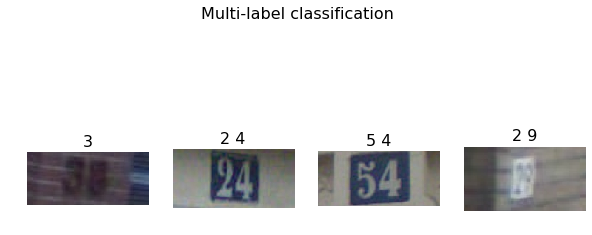

In [46]:
samples = train_df.sample(4)
list_paths = [f"{home_dir}train/{i}.png" for i in list(samples['image_name'])]
titles=list(samples['tags'])
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In [47]:
f_model = resnet18

In [48]:
label_csv = os.path.join(home_dir, 'train.csv')
bb_csv = os.path.join(home_dir, 'train_boxes.csv')
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [49]:
train_df = pd.read_csv(label_csv)
train_df['tags'] = train_df.tags.apply(lambda x: [float(i) for i in x.split(' ')])

In [50]:
((val_label,trn_label),) = split_by_idx(val_idxs, train_df)

In [51]:
def get_data(sz, bs=30):
    aug_tfms = [RandomRotate(3, p=0.5, tfm_y=TfmType.COORD),
                RandomLighting(0.05, 0.05, tfm_y=TfmType.COORD), 
                RandomStretch(max_stretch=0.5, tfm_y=TfmType.COORD),
               ]
    tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=aug_tfms)
    return ImageClassifierData.from_csv(home_dir, 'train', bb_csv, tfms=tfms, bs=bs, 
                                        suffix='.png', val_idxs=val_idxs, test_name='test',
                                        continuous=True, num_workers=4)

In [52]:
sz = 64
data = get_data(64)

In [53]:
x, y = data.trn_ds[0]

In [54]:
x.shape, y

((3, 64, 64), array([10., 22., 58., 27., 10., 28., 59., 35.], dtype=float32))

In [55]:
y

array([10., 22., 58., 27., 10., 28., 59., 35.], dtype=float32)

In [56]:
from matplotlib import patches, patheffects
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def get_big_bounding_box(boxes):
    # top, left, bottom, right
    return np.array([min(boxes[:, 0]), min(boxes[:,1]), max(boxes[:, 2]), max(boxes[:, 3])])

def draw_im(im, boxes, cats, draw_one_box=False):
    ax = show_img(im, figsize=(8,4))
    if draw_one_box:
        b = bb_hw(boxes)
        draw_rect(ax, b)
    else:
        for b, c in zip(boxes, cats):
            b = bb_hw(b)
            draw_rect(ax, b)
            draw_text(ax, b[:2], c, sz=16)

In [57]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, labels, sz):
        self.ds,self.labels = ds,labels
        self.sz = ds.sz
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x, y = self.ds[i]
        boxes = y.reshape((-1, 4))
        box = get_big_bounding_box(boxes) / sz
        return (x, ((len(self.labels[i])-1), box))

In [58]:
len(trn_label), len(val_label)

(26722, 6680)

In [59]:
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [60]:
x, y = data.trn_ds[4]
print(x.shape, y)

(3, 64, 64) (2, array([0.26562, 0.34375, 0.875  , 0.60938], dtype=float32))


(1, array([0.     , 0.35938, 0.9375 , 0.625  ], dtype=float32))


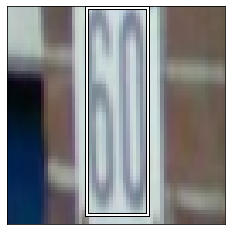

In [61]:
x, y = data.trn_ds[103]
img = data.val_ds.ds.denorm(to_np(x))[0]
boxes = y[1] * sz
draw_im(img, boxes, y[1], draw_one_box=True)
print(y)

In [63]:
class CountHead(nn.Module):
    def __init__(self, n):
        super().__init__()
        self.adaptive = AdaptiveConcatPool2d((1,1))
        self.flatten = Flatten()
        self.layer1 = nn.Sequential(nn.Dropout(p=0.2), nn.Linear(n, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer2 = nn.Sequential(nn.Linear(512, 512), nn.BatchNorm1d(512), nn.ReLU())
        self.layer31 = nn.Sequential(nn.Linear(512, 6))
        # apply sigmoid to make sure output in range [0..1]. 
        # This is the coordinates of the smallest box that corver all number.
        self.layer32 = nn.Sequential(nn.Linear(512, 4), nn.Sigmoid())
        
    def forward(self, x):
        out = self.adaptive(x)
        out = self.flatten(out)
        out = self.layer1(out)
        out = self.layer2(out)
        label = self.layer31(out)
        box = self.layer32(out)
        return [label, box] # output of the model are number of digit and the bounding box.

In [26]:
def custome_accuracy(input:list, targs:list):
    "Compute accuracy with `targs` when `input` is bs * n_classes."
    input = input[0]
    targs = targs[0]
    n = targs.shape[0]
    input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    return (input==targs).float().mean()

In [27]:
count_head = CountHead(1024)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=count_head)
learn = ConvLearner(data, models, metrics=[custome_accuracy])
learn.opt_fn = optim.Adam

In [28]:
count_head

CountHead(
  (adaptive): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=(1, 1))
    (mp): AdaptiveMaxPool2d(output_size=(1, 1))
  )
  (flatten): Flatten()
  (layer1): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=1024, out_features=512, bias=True)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer31): Sequential(
    (0): Linear(in_features=512, out_features=6, bias=True)
  )
  (layer32): Sequential(
    (0): Linear(in_features=512, out_features=4, bias=True)
    (1): Sigmoid()
  )
)

In [29]:
images, labels = next(iter(data.trn_dl))

In [30]:
images.shape, labels[0].shape, labels[1].shape

(torch.Size([30, 3, 64, 64]), torch.Size([30]), torch.Size([30, 4]))

In [31]:
pred = learn.model(images)

In [32]:
pred[0].shape, pred[1].shape

(torch.Size([30, 6]), torch.Size([30, 4]))

In [33]:
class MSECustomize(nn.Module):
    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()
        self.box_loss = nn.L1Loss()
    def forward(self, pred, targ):   
        return self.loss(pred[0], targ[0]) + 10 * self.box_loss(pred[1], targ[1]) 

In [34]:
learn.crit = MSECustomize()

In [35]:
learn.crit(pred, labels)

tensor(4.5420, device='cuda:0', grad_fn=<AddBackward0>)

In [36]:
# learn.summary()

In [37]:
# lr = 0.1
# learn.lr_find(1e-5,10.)

In [38]:
# learn.sched.plot()

In [39]:
lr = 3e-4

In [40]:
sz = 64
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [41]:
learn.set_data(data)
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      1.445706   1.431076   0.627545  
    1      1.410982   1.38227    0.641617                    
    2      1.386286   1.374309   0.644761                    



[1.3743091050736205, 0.6447605147154746]

In [42]:
lrs = np.array([lr/100,lr/10,lr])

In [43]:
learn.freeze_to(-2)

In [44]:
# lrf=learn.lr_find(lrs/1000)
# learn.sched.plot(1)

In [45]:
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      1.299923   1.297017   0.692515  
    1      1.171875   1.140641   0.743563                    
    2      1.098319   1.056459   0.767814                    



[1.0564591539298702, 0.7678144150329921]

In [46]:
learn.unfreeze()

In [47]:
learn.fit(lrs, 3, cycle_len=2)

epoch      trn_loss   val_loss   custome_accuracy            
    0      1.076603   1.050828   0.769461  
    1      1.04719    1.011825   0.779042                    
    2      0.980015   0.970307   0.788473                    
    3      0.95502    0.94104    0.801647                    
    4      0.936311   0.923414   0.801647                    
    5      0.89196    0.895244   0.812126                    



[0.8952436421267287, 0.8121257962402469]

In [48]:
learn.save('svhn_box_001')

In [49]:
learn.load('svhn_box_001')

In [50]:
# plot some images with length of box:


In [51]:
sz = 128
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [52]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      1.216294   1.091209   0.766018  
    1      1.203527   1.071852   0.767365                    
    2      1.141104   1.04931    0.770509                    



[1.0493098947994723, 0.7705090262754235]

In [53]:
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      0.978243   0.877153   0.83024   
    1      0.858546   0.78949    0.848503                    
    2      0.825312   0.753961   0.856138                    



[0.753961438815037, 0.8561377751970005]

In [54]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2)

epoch      trn_loss   val_loss   custome_accuracy            
    0      0.798046   0.739807   0.853144  
    1      0.767103   0.720055   0.861826                    
    2      0.742894   0.70564    0.864072                    
    3      0.696718   0.693665   0.863623                    
    4      0.70464    0.691698   0.868713                    
    5      0.665825   0.686882   0.87021                     



[0.6868819801839526, 0.8702096310025917]

In [55]:
learn.save('svhn_box_002')

In [56]:
learn.load('svhn_box_002')

In [57]:
sz = 256
data = get_data(sz)
trn_ds2 = ConcatLblDataset(data.trn_ds, list(trn_label.tags), sz)
val_ds2 = ConcatLblDataset(data.val_ds, list(val_label.tags), sz)
data.trn_dl.dataset = trn_ds2
data.val_dl.dataset = val_ds2

In [58]:
learn.set_data(data)
learn.freeze()
learn.fit(lr, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      1.189625   1.02028    0.79012   
    1      1.106184   0.974799   0.805838                    
    2      1.076804   0.945314   0.812874                    



[0.9453135347830321, 0.812874299948087]

In [59]:
learn.freeze_to(-2)
learn.fit(lrs, 3, cycle_len=1)

epoch      trn_loss   val_loss   custome_accuracy            
    0      0.906509   0.759408   0.863623  
    1      0.78884    0.7099     0.877395                    
    2      0.761766   0.664114   0.882485                    



[0.6641141082087677, 0.8824850789265718]

In [60]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_box_003')

epoch      trn_loss   val_loss   custome_accuracy            
    0      0.738677   0.662128   0.883832  
    1      0.736643   0.640059   0.888024                    
    2      0.664946   0.619318   0.894162                    
    3      0.698071   0.636263   0.885928                    
    4      0.638502   0.601026   0.895659                    
    5      0.561819   0.591625   0.899701                    
    6      0.547796   0.588057   0.898054                    



In [61]:
learn.load('svhn_box_003')

In [62]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save('svhn_box_004')

epoch      trn_loss   val_loss   custome_accuracy            
    0      0.577451   0.584878   0.901347  
    1      0.593127   0.590049   0.901647                    
    2      0.526784   0.582022   0.906437                    
    3      0.56271    0.612319   0.898802                    
    4      0.539246   0.590503   0.905988                    
    5      0.476089   0.580615   0.908234                    
    6      0.476508   0.589001   0.906886                    



In [64]:
# After adding bounding box information. We don't see any improvement on accuracy.
# Let review the result on test set to see what kind of sample model get wrong.

In [63]:
ls /fast/data/SVHN/models

svhn_001.h5           svhn_002_resnet32.h5  svhn_box_001.h5  svhn_box_004.h5
svhn_001_resnet32.h5  svhn_003.h5           svhn_box_002.h5  svhn_number_001.h5
svhn_002.h5           svhn_003_resnet32.h5  svhn_box_003.h5  tmp.h5
